In [299]:
# Example performance of HMM-based realignment:

%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob
import sys

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import DataStruct
from firingrate import raster2FR
from plotting_utils import figSize
from lineplots import plotsd
from hmm_utils import *
from hmm import *
from session_utils import *
from recalibration_utils import *


from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA


files          = glob.glob('D:/T5_ClosedLoop/*')
click_sessions = list()

for f in files:
    dat   = DataStruct(f)
    if dat.decClick_continuous.max() > 0:
        click_sessions.append(f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\ghwilson\Anaconda3\envs\Speech\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### train linear regression on day 0, get baseline performance measure


In [5]:

# Get initial day performance and decoder:
day0       = DataStruct(click_sessions[0], alignScreens = True)
train_frac = 0.5
task       = None
sigma      = None
blocks     = None

train_x, test_x, train_y, test_y  = getTrainTest(day0, train_frac = train_frac, sigma = sigma, task = task, blocks = blocks, return_flattened = True)
ref_means                         = train_x.mean(axis = 0)
ref_scores, ref_decoder           = traintest_DecoderSupervised([train_x], [test_x], [train_y], [test_y])
 
print('Performance on day 0: R^2 = ', np.mean(ref_scores))

Performance on day 0: R^2 =  0.36029636197553316


In [376]:
neural      = [day0.TX_continuous[:10000, :]]
cursorPos   = [day0.cursorPos_continuous[:10000, :]]
clickSignal = [day0.decClick_continuous[:10000]]
targetPos   = [day0.targetPos_continuous[:10000, :]]

Text(0, 0.5, 'Channels')

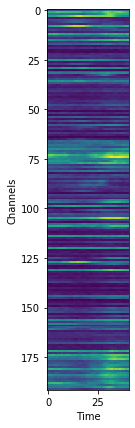

In [377]:
window       = 20

click_times  = np.where(clickSignal[0] == 1)[0][:-4]
n_clicks     = len(click_times)

neural_click = np.zeros(((window * 2) + 1, 192, n_clicks))


for i, t in enumerate(click_times):
    neural_click[:, :, i] = neural[0][(t - window):(t + window + 1), :]
avgd = np.mean(neural_click, axis = 2)


plt.imshow(avgd.T)
plt.xlabel('Time')
plt.ylabel('Channels')

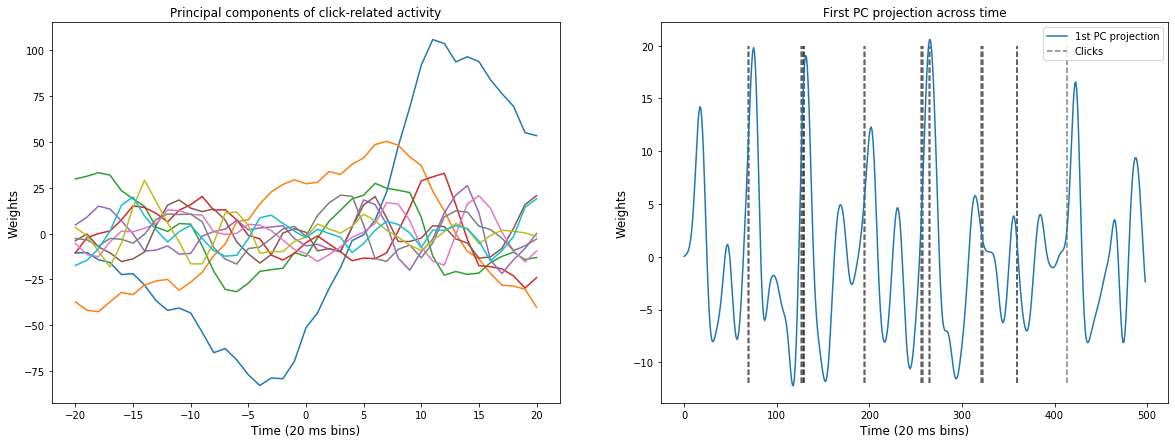

In [365]:
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
figSize(7, 20)

pca  = PCA().fit(avgd)

plt.subplot(1, 2, 1)
components = pca.transform(avgd)
plt.plot(np.arange(-1 * window, window + 1), components[:, :10])
plt.xlabel('Time (20 ms bins)', fontsize = 12)
plt.ylabel('Weights', fontsize = 12)
plt.title('Principal components of click-related activity', fontsize = 12)

plt.subplot(1, 2, 2)
timecourse = gaussian_filter1d((neural[0] - neural[0].mean(axis = 0)).dot(pca.components_[0, :]), sigma = 5)

plt.plot(np.diff(timecourse[:500]), label = '1st PC projection')
plt.vlines(click_times[:20], ymin = -12, ymax = 20, color = 'k', linestyle = '--', alpha = 0.5, label = 'Clicks')
plt.xlabel('Time (20 ms bins)', fontsize = 12)
plt.ylabel('Weights', fontsize = 12)
plt.title('First PC projection across time', fontsize = 12)
plt.legend()

In [403]:
from recalibration_utils import get_WindowedFeatures, ClickDecoder
from sklearn.model_selection import train_test_split


train_x, test_x, train_y, test_y = train_test_split(neural[0], clickSignal[0], train_size = 0.8, shuffle = False)


window       = 20
padding      = 0
n_components = 5

classifier = ClickDecoder(window, n_components).train(train_x, train_y)
probs      = classifier.predict_probs(test_x)[:, 1]

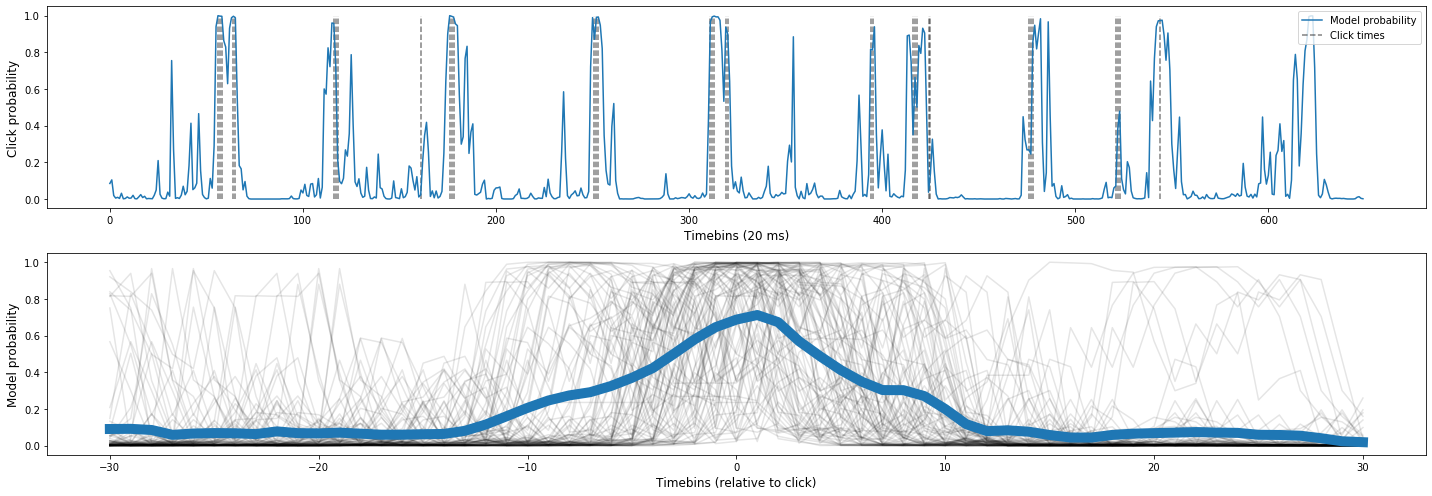

In [404]:

plt.subplot(2, 1, 1)
plt.plot(classifier.predict_probs(test_x)[:650, 1], label = 'Model probability')
plt.vlines(np.where(test_y == 1)[0][:34], ymin = 0, ymax = 1, color = 'k', linestyle = '--', alpha = 0.5, label = 'Click times')
plt.xlabel('Timebins (20 ms)', fontsize = 12)
plt.ylabel('Click probability', fontsize = 12)
plt.legend(loc = 'upper right')

plt.subplot(2, 1, 2)
view_window = 30

click_times = np.where([test_y == 1])[1]
click_times = click_times[np.logical_and(click_times > view_window, click_times < len(test_y) - view_window)]
click_probs = np.zeros((len(click_times), view_window * 2 + 1))

for i, t in enumerate(click_times):
    snippet           = probs[(t - view_window ):(t + view_window + 1 )]
    click_probs[i, :] = snippet 
    plt.plot(np.arange(-1 * view_window, view_window + 1), snippet, color = 'k', alpha = 0.1)
    
plt.plot(np.arange(-1 * view_window, view_window + 1), click_probs.mean(axis = 0), linewidth = 10)
plt.xlabel('Timebins (relative to click)', fontsize = 12)
plt.ylabel('Model probability', fontsize = 12)

plt.tight_layout()

## Click decoder decay dynamics

Now we'll look at click decoder stability across time, using pairs of sessions from the subselected click sessions we found earlier.

In [ ]:
# General parameters:
i          = 2  
train_frac = 0.5
task       = None


# HMM setup:
probThreshold = 0.4
gridSize      = 20  
stayProb      = 0.9999
vmKappa       = 2
probThreshold = 0.4

nStates       = gridSize**2
stateTrans    = np.eye(nStates)*stayProb #Define the state transition matrix, which assumes uniform transition probability of transitioning to new state
targLocs      = get_DiscreteTargetGrid(day0, gridSize = gridSize, task = task)

for x in range(nStates):
    idx                = np.setdiff1d(np.arange(nStates), x)
    stateTrans[x, idx] = (1-stayProb)/(nStates-1)
pStateStart = np.zeros((nStates,1)) + (1/nStates)


new_dat     = DataStruct(click_sessions[2], alignScreens = True)

train_x, cursorPos, train_y, test_x, _, test_y = prep_HMMData(new_dat, train_frac = train_frac, task = task, return_click = True, return_flattened = True)

In [ ]:
neural      = [dat.TX_continuous[:10000, :]]
cursorPos   = [dat.cursorPos_continuous[:10000, :]]
clickSignal = [dat.decClick_continuous[:10000, :]]
targetPos   = [dat.targetPos_continuous[:10000, :]]

In [142]:
dat.dec

(120615, 2)

In [11]:
neural    = [train_x]
cursorPos = [cursorPos]


In [124]:
n_trials               = len(neural)
targStates, pTargState = list(), list()

neural_flattened       = np.concatenate(neural)
cursorPos_flattened    = np.concatenate(cursorPos)

for i in range(n_trials):
    rawDecTraj = ref_decoder.predict(neural[i] - neural_flattened.mean(axis = 0))
    targs      = py_hmmviterbi_vonmises(rawDecTraj, stateTrans, targLocs, cursorPos[i], pStateStart, vmKappa)[0]
    pTargs     = py_hmmdecode_vonmises(rawDecTraj, stateTrans, targLocs, cursorPos[i], pStateStart, vmKappa)[0]
    targStates.append(targs)
    pTargState.append(pTargs)

targStates  = np.concatenate(targStates)
pTargState  = np.concatenate(pTargState)

maxProb     = np.max(pTargState, axis = 0)              
highProbIdx = np.where(maxProb > probThreshold)[0]                   # find time periods of high certainty

inferredTargLoc = targLocs[targStates.astype('int').flatten(),:] #